In [1]:
import numpy as np
import obspy
import glob
import pandas as pd
from matplotlib import cm
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
from scipy.io import loadmat
from scipy.signal import savgol_filter
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from matplotlib.offsetbox import AnchoredText
from datetime import datetime, date, time, timedelta
import h5py
from math import radians,sin,cos,atan2,sqrt
from scipy import signal

import pyproj
geodesic = pyproj.Geod(ellps='WGS84')

In [2]:
import pandas as pd

index=pd.read_excel('JMA.xlsx')['Index']
latitude=pd.read_excel('JMA.xlsx')['Latitude']
longitude=pd.read_excel('JMA.xlsx')['Longitude']
magnitude=pd.read_excel('JMA.xlsx')['Magnitude']
date=pd.read_excel('JMA.xlsx')['Date']
time=pd.read_excel('JMA.xlsx')['Time']

In [3]:
def moving(v,n):
    medians=np.zeros(len(v))
    for i in range(len(v)):
        medians[i]=np.median(v[np.max((0,i-n)):np.min(((i+n),len(v)))])
    return medians

In [35]:
df=loadmat('new_station_location_airgun_with_prof_FINAL_v2.mat')
depth=df['depth']
lats=df['latall']
lons=df['lonall']

slope = []
distslope = 40
half_len = int(distslope/2)
for i in range(13722):
    slope.append(abs(depth[i-half_len] - depth[i+half_len])/(distslope*5)*100)

In [5]:
snrs=glob.glob('SNR_new/*gaussian_snr.npy')
snr=np.load(snrs[0])
for i in range(1,len(snrs)):
    snr+=np.load(snrs[i])
snr=snr/35
print(snr.shape)

(2745, 50)


In [6]:
eqmag=[]
eqsnrs=glob.glob('SNR_new/*hz_snr.npy')
eqsnr=np.load(eqsnrs[0])
eqmag.append(float(eqsnrs[0].split('M')[1].split('_')[0]))
for i in range(1,len(eqsnrs)):
    eqmag.append(float(eqsnrs[i].split('M')[1].split('_')[0]))
    eqsnr=np.vstack((eqsnr,np.load(eqsnrs[i])))
print(eqsnr.shape)
ave_snr=np.mean(eqsnr,axis=1)

(35, 2745)


In [7]:
ids=[]
ave_anr=[]
for eq in eqsnrs:
    ids.append(int(eq[13:17]))
    
print(ids)

eqlats=[]
eqlons=[]
mags=[]
times=[]
for i in ids:
    eqlats.append(latitude[i-1])
    eqlons.append(longitude[i-1])
    mags.append(float(magnitude[i-1][0:3]))
    times.append(str(datetime.combine(date[i-1], time[i-1])-timedelta(seconds=9*3600)))
    
# eqlats=np.array(eqlats)
# eqlons=np.array(eqlons)
# mags=np.array(mags)

[2350, 5581, 4574, 474, 5482, 3424, 5240, 110, 834, 3642, 119, 373, 3306, 4566, 2266, 3752, 2750, 1253, 746, 1662, 1784, 744, 94, 1476, 3734, 3582, 2760, 4845, 3761, 1580, 378, 873, 3497, 5490, 2819]


In [8]:
def cal_dist(lati1,long1,lati2,long2):
    
    ### lati2 and long2 are for DAS center
    ### lati1 and long1 are for eq epicenter
    
    R = 6373.0
    
    lat1 = radians(lati1)
    lon1 = radians(long1)
    lat2 = radians(lati2)
    lon2 = radians(long2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    
    a,b,c=geodesic.inv(long1,lati1,long2, lati2)
    if b >=0:
        back_azimuth=b
    else:
        back_azimuth=b+360
    
    
    return distance,back_azimuth

In [9]:
lati2=lats[6861]
long2=lons[6861]

dist=[]
backa=[]
for e in range(len(eqlats)):
    a,b=cal_dist(eqlats[e],eqlons[e],lati2,long2)
    dist.append(a)
    backa.append(b)

/tmp/ipykernel_583600/3228863489.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lat2 = radians(lati2)
/tmp/ipykernel_583600/3228863489.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lon2 = radians(long2)


In [10]:
### write to an Excel spreadsheet
df=np.array([eqlats,eqlons,np.around(dist,2),np.around(backa,2),mags,np.around(ave_snr,2)]).T
df=pd.DataFrame(df,index=times,
           columns=['Latitude', 'Longitude','Distance (km)','Back azimuth','Magnitude','Average SNR'])
df.to_excel(excel_writer= 'for_latex.xlsx')

In [11]:
filtered=np.load('filtered_noise.npy')
unfiltered=np.load('unfiltered_noise.npy')

In [13]:
eqsnr.shape

(35, 2745)

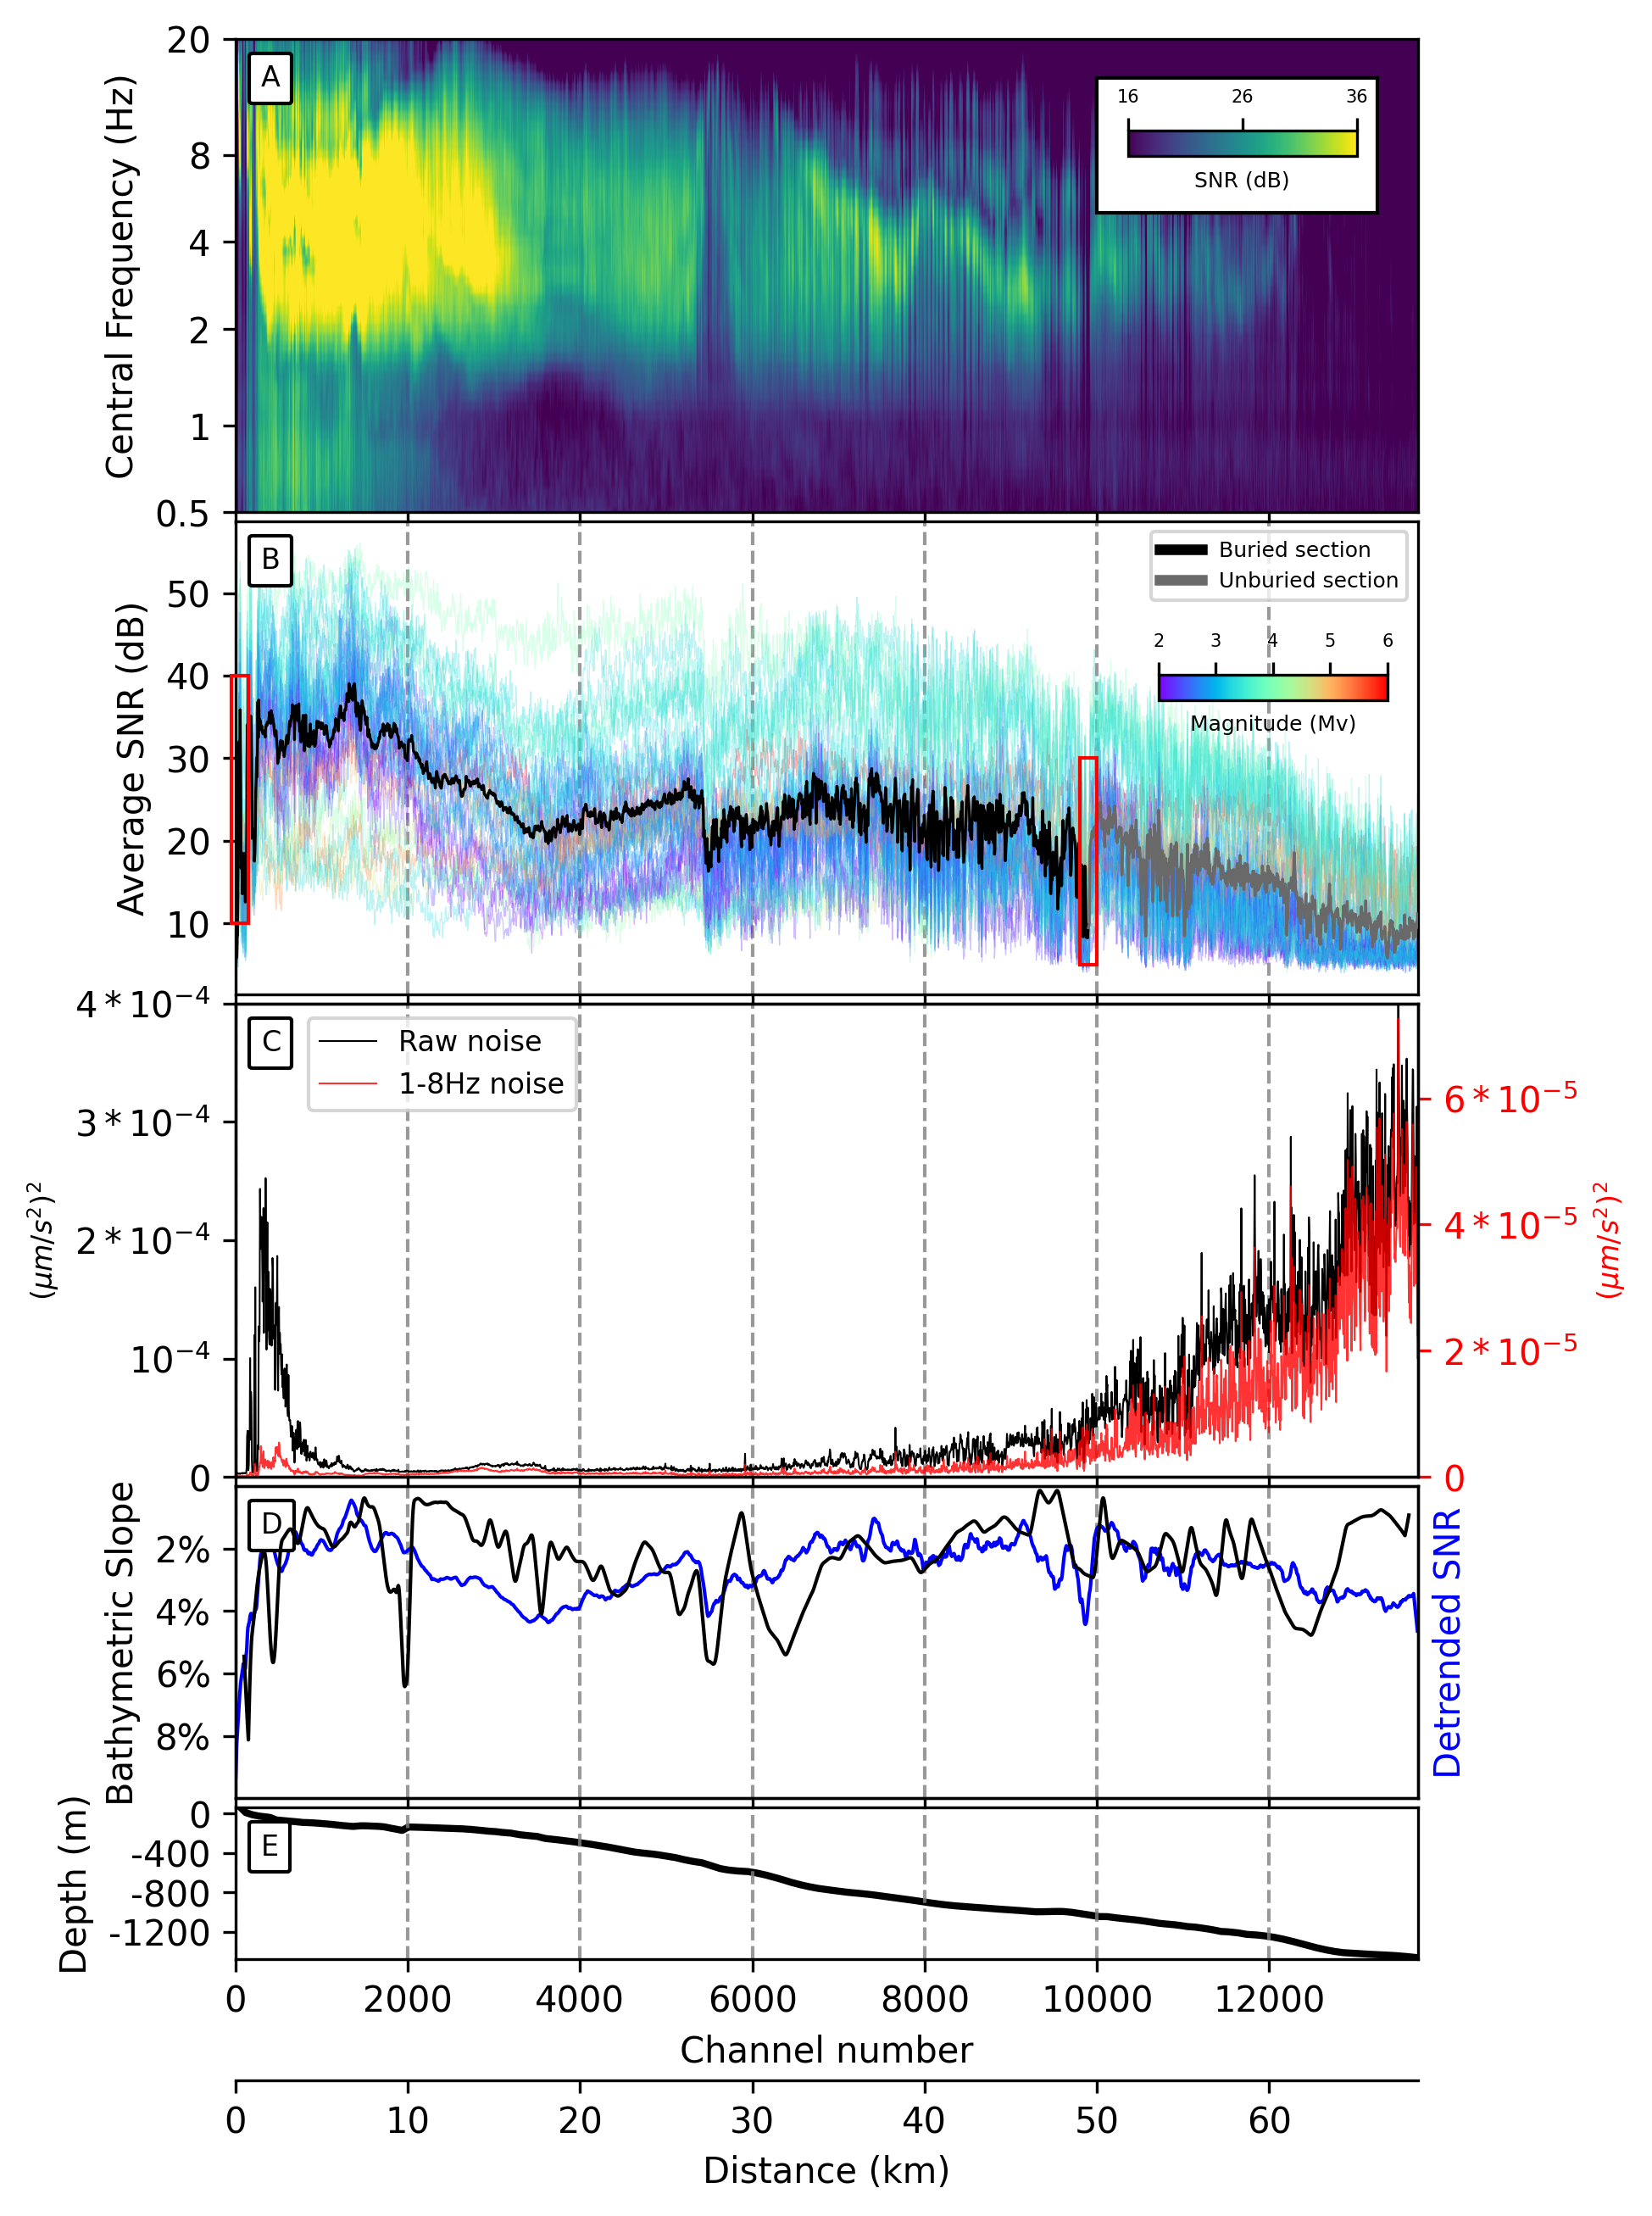

In [117]:
# fig, (ax0,ax1,ax2,ax3) = plt.subplots(nrows=4,figsize=(6,10))

fig=plt.figure(figsize=(6,10),dpi=300)
fig.subplots_adjust(hspace=0.06)

ax0 = plt.subplot2grid(shape=(12,9), loc=(0,0), colspan=9,rowspan=3)
ax1 = plt.subplot2grid(shape=(12,9), loc=(3,0), colspan=9,rowspan=3)
ax2 = plt.subplot2grid(shape=(12,9), loc=(6,0), colspan=9,rowspan=3)
ax3 = plt.subplot2grid(shape=(12,9), loc=(9,0), colspan=9,rowspan=2)
ax4 = plt.subplot2grid(shape=(12,9), loc=(11,0), colspan=9,rowspan=1)

normalize = mcolors.Normalize(vmin=2, vmax=6)
colormap = cm.rainbow

### Subplot1
mesh=ax0.imshow(snr.T*2,aspect='auto',vmin=16,vmax=36)
ax0.set_xticks([])
ax0.set_yticks([0,9,19,28,37,49])
ax0.set_yticklabels([0.5,1,2,4,8,20])
ax0.set_ylabel('Central Frequency (Hz)',fontsize=10)
ax0.invert_yaxis()
ax0.set_ylim(0,49)

rect=patches.Rectangle((2000,31),650,14, linewidth=1, edgecolor='black', facecolor='white')
ax0.add_patch(rect)

at = AnchoredText('A',prop=dict(size=8), frameon=True,loc=2)
at.patch.set_boxstyle('round',pad=0,rounding_size=0.1)
ax0.add_artist(at)

c1=fig.add_axes([0.71,0.834,0.15,0.01])
cbar=fig.colorbar(mesh, cax=c1,orientation='horizontal')
cbar.ax.tick_params(labelsize=5)
cbar.set_alpha(0.3)
cbar.ax.xaxis.set_ticks([16,26,36]) 
cbar.ax.xaxis.set_ticks_position("top")
cbar.set_label('SNR (dB)',rotation=0,fontsize=6)

ax0.set_xlim(0,2745)
ax0.set_xticks([0,400,800,1200,1600,2000,2400])
ax0.set_xticklabels([])

##subplot2
ax1.xaxis.set_major_locator(plt.NullLocator())
ax1.plot(np.arange(1980),(np.mean(eqsnr,axis=0))[:1980]*2,c='k',alpha=1,zorder=999,linewidth=0.8)
ax1.plot(np.arange(1980,2745),(np.mean(eqsnr,axis=0))[1980:2745]*2,c='dimgrey',alpha=1,zorder=999,linewidth=0.8)
ax1.plot([-1,-2],[5,5],c='k',alpha=1,label='Buried section',zorder=999,linewidth=3)
ax1.plot([-1,-2],[5,5],c='dimgrey',alpha=1,label='Unburied section',zorder=999,linewidth=3)
ax1.set_xticks([0,400,800,1200,1600,2000,2400])
ax1.set_xticklabels([])
ax1.set_yticks([10,20,30,40,50])
ax1.set_yticklabels([10,20,30,40,50],c='k')
ax1.set_ylabel('Average SNR (dB)', fontsize=10,c='k')
ax1.set_xlim(0,2745)
ax1.grid(color='grey', linestyle='--', linewidth=1,axis='x',alpha=0.8)

for i in range(35):
    ax1.plot(np.arange(2745),eqsnr[i,:]*2,c=colormap(normalize(eqmag[i])),alpha=0.3,linewidth=0.3)

###legend
legend=ax1.legend(loc='upper right', fontsize=6)
legend.get_frame().set_facecolor('white')

###cbar

normalize = mcolors.Normalize(vmin=2, vmax=6)
colormap = cm.rainbow
c2=fig.add_axes([0.73,0.62,0.15,0.01])
cbar=fig.colorbar(cm.ScalarMappable(norm=normalize, cmap=colormap), cax=c2,orientation='horizontal')
cbar.ax.tick_params(labelsize=5)
cbar.set_alpha(0.3)
cbar.ax.xaxis.set_ticks_position("top")
cbar.set_label('Magnitude (Mv)',rotation=0,fontsize=6)

at = AnchoredText('B',prop=dict(size=8), frameon=True,loc=2)
at.patch.set_boxstyle('round',pad=0,rounding_size=0.1)
ax1.add_artist(at)

###subplot 3

ax22=ax2.twinx()
lns1=ax2.plot(np.arange(0,2745),unfiltered,'k',lw=0.5,label='Raw noise')
ax2.set_xlim(0,2745)
ax2.set_ylim(0,40)
ax2.set_xticks([0,400,800,1200,1600,2000,2400])
ax2.set_xticklabels([])
ax2.set_yticks([0,10,20,30,40])
ax2.set_yticklabels(['0',r'$10^{-4}$',r'$2*10^{-4}$',r'$3*10^{-4}$',r'$4*10^{-4}$'])
ax2.grid(color='grey', linestyle='--', linewidth=1,axis='x',alpha=0.8)
# ax2.set_ylabel('Average 10s noise energy \n($\Sigma a^2, (\mu m/s^2)^2$)',fontsize=8)
ax2.set_ylabel('$(\mu m/s^2)^2$',fontsize=8,rotation=90)

lns2=ax22.plot(np.arange(0,2745),filtered,'r',lw=0.5,alpha=0.8,label='1-8Hz noise')
ax22.set_ylim(0,7.5)
ax22.set_yticks([0,2,4,6])
ax22.set_yticklabels(['0',r'$2*10^{-5}$',r'$4*10^{-5}$',r'$6*10^{-5}$'])
# ax22.set_ylabel('Average 10s noise energy \nbetween 1-8Hz ($\Sigma a^2, (\mu m/s^2)^2$)',fontsize=8,rotation=90)
ax22.set_ylabel('$(\mu m/s^2)^2$',fontsize=8,rotation=90)
# ax22.spines['right'].set_color('r')
ax22.yaxis.label.set_color('r')
ax22.tick_params(axis='y', colors='r')

lns=lns1+lns2
labs=[l.get_label() for l in lns]
ax2.legend(lns,labs,bbox_to_anchor=(0.3,1),loc=0,fontsize=8)

at=AnchoredText('C',prop=dict(size=8), frameon=True,loc=2)
at.patch.set_boxstyle('round',pad=0,rounding_size=0.1)
ax2.add_artist(at)

###subplot 4
ax3.set_xlim(0,2745)
ax3.set_xticks([0,400,800,1200,1600,2000,2400])
ax3.set_xticklabels([])

ax33=ax3.twinx()
# ax33.plot(np.arange(40,2745),slope[40*5:2745*5:5],c='k',alpha=1,linewidth=2,zorder=99)
ax33.plot(np.arange(20,2725),np.convolve(np.ones(20)/20,slope[100:2725*5:5],'same'),c='k',alpha=1,linewidth=1)
ax33.set_ylabel('Bathymetric Slope',fontsize=10,c='k')
ax33.set_yticks([2,4,6,8])
ax33.set_yticklabels(['2%','4%','6%','8%'],c='k')
ax33.set_ylim([10,0])

at=AnchoredText('D',prop=dict(size=8), frameon=True,loc=2)
at.patch.set_boxstyle('round',pad=0,rounding_size=0.1)
ax3.add_artist(at)

ax3.plot(np.arange(2745),signal.detrend(np.convolve(np.ones(20)/20,np.mean(eqsnr,axis=0)[:2745]*2,'same')),c='b',linewidth=1)
ax3.set_ylabel('Detrended SNR',fontsize=10,c='blue')
ax3.set_yticks([])
# ax3.set_yticklabels([0,-200,-400,-600,-800,-1000,-1200,-1400],c='blue')
# ax3.set_ylim(-1480,60)
ax3.tick_params(axis='y', colors='blue')
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()
ax3.grid(color='grey', linestyle='--', linewidth=1,axis='x',alpha=0.8)

ax33.yaxis.set_label_position("left")
ax33.yaxis.tick_left()

### subplot 5
ax4.plot(np.arange(2745),depth[:2745*5:5],c='k',linewidth=2,zorder=0)
ax4.set_ylabel('Depth (m)',fontsize=10,c='k')
ax4.set_yticks([0,-400,-800,-1200])
ax4.set_yticklabels([0,-400,-800,-1200],c='k')
ax4.set_ylim(-1480,60)
ax4.grid(color='grey', linestyle='--', linewidth=1,axis='x',alpha=0.8)

ax4.set_xticks([0,400,800,1200,1600,2000,2400])
ax4.set_xticklabels([0,2000,4000,6000,8000,10000,12000])
ax4.set_xlabel('Channel number',fontsize=10)
ax4.set_xlim(0,2745)

at=AnchoredText('E',prop=dict(size=8), frameon=True,loc=2)
at.patch.set_boxstyle('round',pad=0,rounding_size=0.1)
ax4.add_artist(at)

secax4=ax4.secondary_xaxis(-0.8)
secax4.set_xlabel('Distance (km)')
secax4.set_xticks([0,400,800,1200,1600,2000,2400])
secax4.set_xticklabels([0,10,20,30,40,50,60])

rect = patches.Rectangle((-10,10),40,30, linewidth=1, edgecolor='r', facecolor='none',clip_on=False,zorder=9999)
ax1.add_patch(rect)
rect = patches.Rectangle((1960,5),40,25, linewidth=1, edgecolor='r', facecolor='none',clip_on=False,zorder=9999)
ax1.add_patch(rect)
# plt.savefig('Figure_3_7.png',dpi=fig.dpi,bbox_inches = 'tight')

In [80]:
def normalize(data):
    return data/np.max(np.abs(data))

In [43]:
np.array(slope)[:,0]

array([787.39573755, 787.41814473, 787.44042133, ...,   2.03836956,
         2.0381963 ,   2.03802453])

In [51]:
signal.detrend(np.convolve(np.ones(20)/20,normalize(np.mean(eqsnr,axis=0)[:2745]*2)))

array([-0.80324154, -0.79575594, -0.78819338, ..., -0.27418635,
       -0.28709049, -0.29912125])

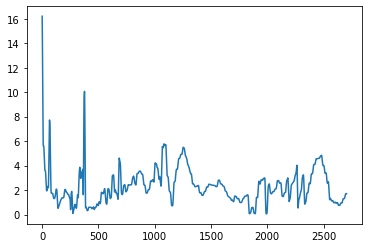

In [93]:
plt.plot(slope[100:2725*5:5])